# Лабораторная работа №5. "ДРЕВОВИДНЫЕ МОДЕЛИ: РЕШАЮЩИЕ ДЕРЕВЬЯ И ИХ КОМПОЗИЦИИ"

In [137]:
import pandas as pd
from category_encoders.binary import BinaryEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import classification_report, roc_auc_score
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

## Предобработка данных

In [75]:
df = pd.read_csv(r"../data/DataSet3-v8.csv")
df

manufacturer_name  model_name transmission   color  odometer_value  \
0                Subaru     Outback    automatic  silver          190000   
1                Subaru     Outback    automatic    blue          290000   
2                Subaru    Forester    automatic     red          402000   
3                Subaru     Impreza   mechanical    blue           10000   
4                Subaru      Legacy    automatic   black          280000   
...                 ...         ...          ...     ...             ...   
38526          Chrysler         300    automatic  silver          290000   
38527          Chrysler  PT Cruiser   mechanical    blue          321000   
38528          Chrysler         300    automatic    blue          777957   
38529          Chrysler  PT Cruiser   mechanical   black           20000   
38530          Chrysler     Voyager    automatic  silver          297729   

       year_produced engine_fuel  engine_has_gas engine_type  engine_capacity  \
0               2010    gasoline           False    gasoline              2.5   
1               2002    gasoline           False    gasoline              3.0   
2               2001    gasoline           False    gasoline              2.5   
3               1999    gasoline           False    gasoline              3.0   
4               2001    gasoline           False    gasoline              2.5   
...              ...         ...             ...         ...              ...   
38526           2000    gasoline           False    gasoline              3.5   
38527           2004      diesel           False      diesel              2.2   
38528           2000    gasoline           False    gasoline              3.5   
38529           2001    gasoline           False    gasoline              2.0   
38530           2000    gasoline           False    gasoline              2.4   

       body_type  has_warranty  state drivetrain  price_usd  is_exchangeable  \
0      universal         False  owned        all   10900.00            False   
1      universal         False  owned        all    5000.00             True   
2            suv         False  owned        all    2800.00             True   
3          sedan         False  owned        all    9999.00             True   
4      universal         False  owned        all    2134.11             True   
...          ...           ...    ...        ...        ...              ...   
38526      sedan         False  owned      front    2750.00             True   
38527  hatchback         False  owned      front    4800.00             True   
38528      sedan         False  owned      front    4300.00            False   
38529    minivan         False  owned      front    4000.00             True   
38530    minivan         False  owned      front    3200.00             True   

       location_region  number_of_photos  up_counter  feature_0  feature_1  \
0         Минская обл.                 9          13      False       True   
1         Минская обл.                12          54      False       True   
2         Минская обл.                 4          72      False       True   
3         Минская обл.                 9          42       True      False   
4      Гомельская обл.                14           7      False       True   
...                ...               ...         ...        ...        ...   
38526     Минская обл.                 5          85      False       True   
38527   Брестская обл.                 4          20      False       True   
38528     Минская обл.                 3          63      False       True   
38529   Брестская обл.                 7         156      False       True   
38530     Минская обл.                 4          73      False      False   

       feature_2  feature_3  feature_4  feature_5  feature_6  feature_7  \
0           True       True      False       True      False       True   
1          False      False       True       True      False      False 

In [76]:
# удаление пропусков
df['engine_capacity']=df['engine_capacity'].fillna(0)
# удаление дублей
df = df.drop_duplicates().reset_index(drop=True)
# перевод категориал. данных в бинар.
bn = BinaryEncoder()
df_bn_obj = bn.fit_transform(df.select_dtypes(include=['object','bool'])).astype('int8')
df_num = df.select_dtypes(exclude=['object', 'bool'])
df = pd.concat([df_num, pd.DataFrame(df_bn_obj)], axis=1)
# EDA
outlier = df[['odometer_value', 'year_produced', 'engine_capacity', 'price_usd', 'number_of_photos', 'up_counter', 'duration_listed']]
Q1 = outlier.quantile(0.25)
Q3 = outlier.quantile(0.75)
IQR = Q3-Q1
df_filtered = outlier[~((outlier < (Q1 - 1.5 * IQR)) |(outlier > (Q3 + 1.5 * IQR))).any(axis=1)]
index_list = list(df_filtered.index.values)
df_filtered = df[df.index.isin(index_list)]

df_reg = df_filtered

In [77]:
data = pd.read_csv(r"../data/weatherAUS.csv")
data

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145455  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145456  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145457  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145458  2017-06-24    Uluru      7.8     27.0       0.0          NaN   
145459  2017-06-25    Uluru     14.9      NaN       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0            NaN           W           44.0          W        WNW   
1            NaN         WNW           44.0        NNW        WSW   
2            NaN         WSW           46.0          W        WSW   
3            NaN          NE           24.0         SE          E   
4            NaN           W           41.0        ENE         NW   
...          ...         ...            ...        ...        ...   
145455       NaN           E           31.0         SE        ENE   
145456       NaN         NNW           22.0         SE          N   
145457       NaN           N           37.0         SE        WNW   
145458       NaN          SE           28.0        SSE          N   
145459       NaN         NaN            NaN        ESE        ESE   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0               20.0          24.0         71.0         22.0       1007.7   
1                4.0          22.0         44.0         25.0       1010.6   
2               19.0          26.0         38.0         30.0       1007.6   
3               11.0           9.0         45.0         16.0       1017.6   
4                7.0          20.0         82.0         33.0       1010.8   
...              ...           ...          ...          ...          ...   
145455          13.0          11.0         51.0         24.0       1024.6   
145456          13.0           9.0         56.0         21.0       1023.5   
145457           9.0           9.0         53.0         24.0       1021.0   
145458          13.0           7.0         51.0         24.0       1019.4   
145459          17.0          17.0         62.0         36.0       1020.2   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm RainToday  \
0            1007.1       8.0       NaN     16.9     21.8        No   
1            1007.8       NaN       NaN     17.2     24.3        No   
2            1008.7       NaN       2.0     21.0     23.2        No   
3            1012.8       NaN       NaN     18.1     26.5        No   
4            1006.0       7.0       8.0     17.8     29.7        No   
...             ...       ...       ...      ...      ...       ...   
145455       1020.3       NaN       NaN     10.1     22.4        No   
145456       1019.1       NaN       NaN     10.9     24.5        No   
145457       1016.8       NaN       NaN     12.5     26.1        No   
145458       1016.5       3.0       2.0     15.1     26.0        No   
145459       1017.9       8.0       8.0     15.0     20.9        No   

       RainTomorrow  
0                No  
1                No  
2                No  
3                No  
4                No  
...             ...  
145455           No  
145456           No  
145457           No  
145458           No  
145459          NaN  

[145460 rows x 23 columns]

In [78]:
# Удаление пропусков
data.dropna(inplace=True,ignore_index=True)
# Перевод категориал. данных в бинарные
f = lambda x : str(x)[5:7]
data['Date'] = data['Date'].transform(f).astype(int)

data['RainToday'] = data['RainToday'].replace("Yes", 1)
data['RainToday'] = data['RainToday'].replace("No", 0)
data['RainTomorrow'] = data['RainTomorrow'].replace("Yes", 1)
data['RainTomorrow'] = data['RainTomorrow'].replace("No", 0)

bn = BinaryEncoder()
data_category = bn.fit_transform(data.select_dtypes(include=['object'])).astype(int)
data_num = data.select_dtypes(exclude=['object'])
data = pd.concat([data_num, pd.DataFrame(data_category)], axis=1)
pd.set_option('display.max_columns', None)
# Балансировка данных
df_0 = data.loc[data['RainTomorrow']==0]
df_0 = df_0.sample(len(data.loc[data['RainTomorrow']==1]))
df_conc = pd.concat([data.loc[data['RainTomorrow']==1], df_0])

data_class = df_conc

## Разделение на тест. и тренир. выборки

In [79]:
x_class=pd.DataFrame(data_class.drop(['RainTomorrow'],axis=1))
y_class=pd.DataFrame(data_class['RainTomorrow'])
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(x_class, y_class, test_size=0.33)

In [81]:
y_reg = pd.DataFrame(df_reg["price_usd"])
x_reg = pd.DataFrame(df_reg.drop(["price_usd"], axis=1))
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x_reg, y_reg, test_size=0.2)

## Дерево классификации

In [44]:
param_grid = {
    "max_depth": range(2,7),
    "min_samples_split": range(2, 5),
    "criterion": ['gini', 'entropy', 'log_loss']
}

gridseach = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid)
gridseach.fit(x_train_c, y_train_c)
gridseach.best_params_

{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 4}

In [59]:
DTC=DecisionTreeClassifier(criterion ='gini', max_depth = 6, min_samples_split=4)
DTC.fit(x_train_c, y_train_c)
y_pred_c=pd.DataFrame(DTC.predict(x_test_c))

In [64]:
print(classification_report(y_test_c, y_pred_c))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      4051
           1       0.77      0.81      0.79      4151

    accuracy                           0.78      8202
   macro avg       0.78      0.78      0.78      8202
weighted avg       0.78      0.78      0.78      8202



In [61]:
# решающие правила (Decision Rules)
print(tree.export_text(DTC))

|--- feature_5 <= 8.15
|   |--- feature_10 <= 69.50
|   |   |--- feature_12 <= 1016.35
|   |   |   |--- feature_6 <= 51.00
|   |   |   |   |--- feature_10 <= 56.50
|   |   |   |   |   |--- feature_14 <= 3.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_14 >  3.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_10 >  56.50
|   |   |   |   |   |--- feature_5 <= 6.35
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_5 >  6.35
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- feature_6 >  51.00
|   |   |   |   |--- feature_10 <= 53.50
|   |   |   |   |   |--- feature_12 <= 1004.05
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_12 >  1004.05
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_10 >  53.50
|   |   |   |   |   |--- feature_6 <= 60.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_6 >  60.00
|   |   |   |   |   |   |--- class: 1
|   |   |--- feat

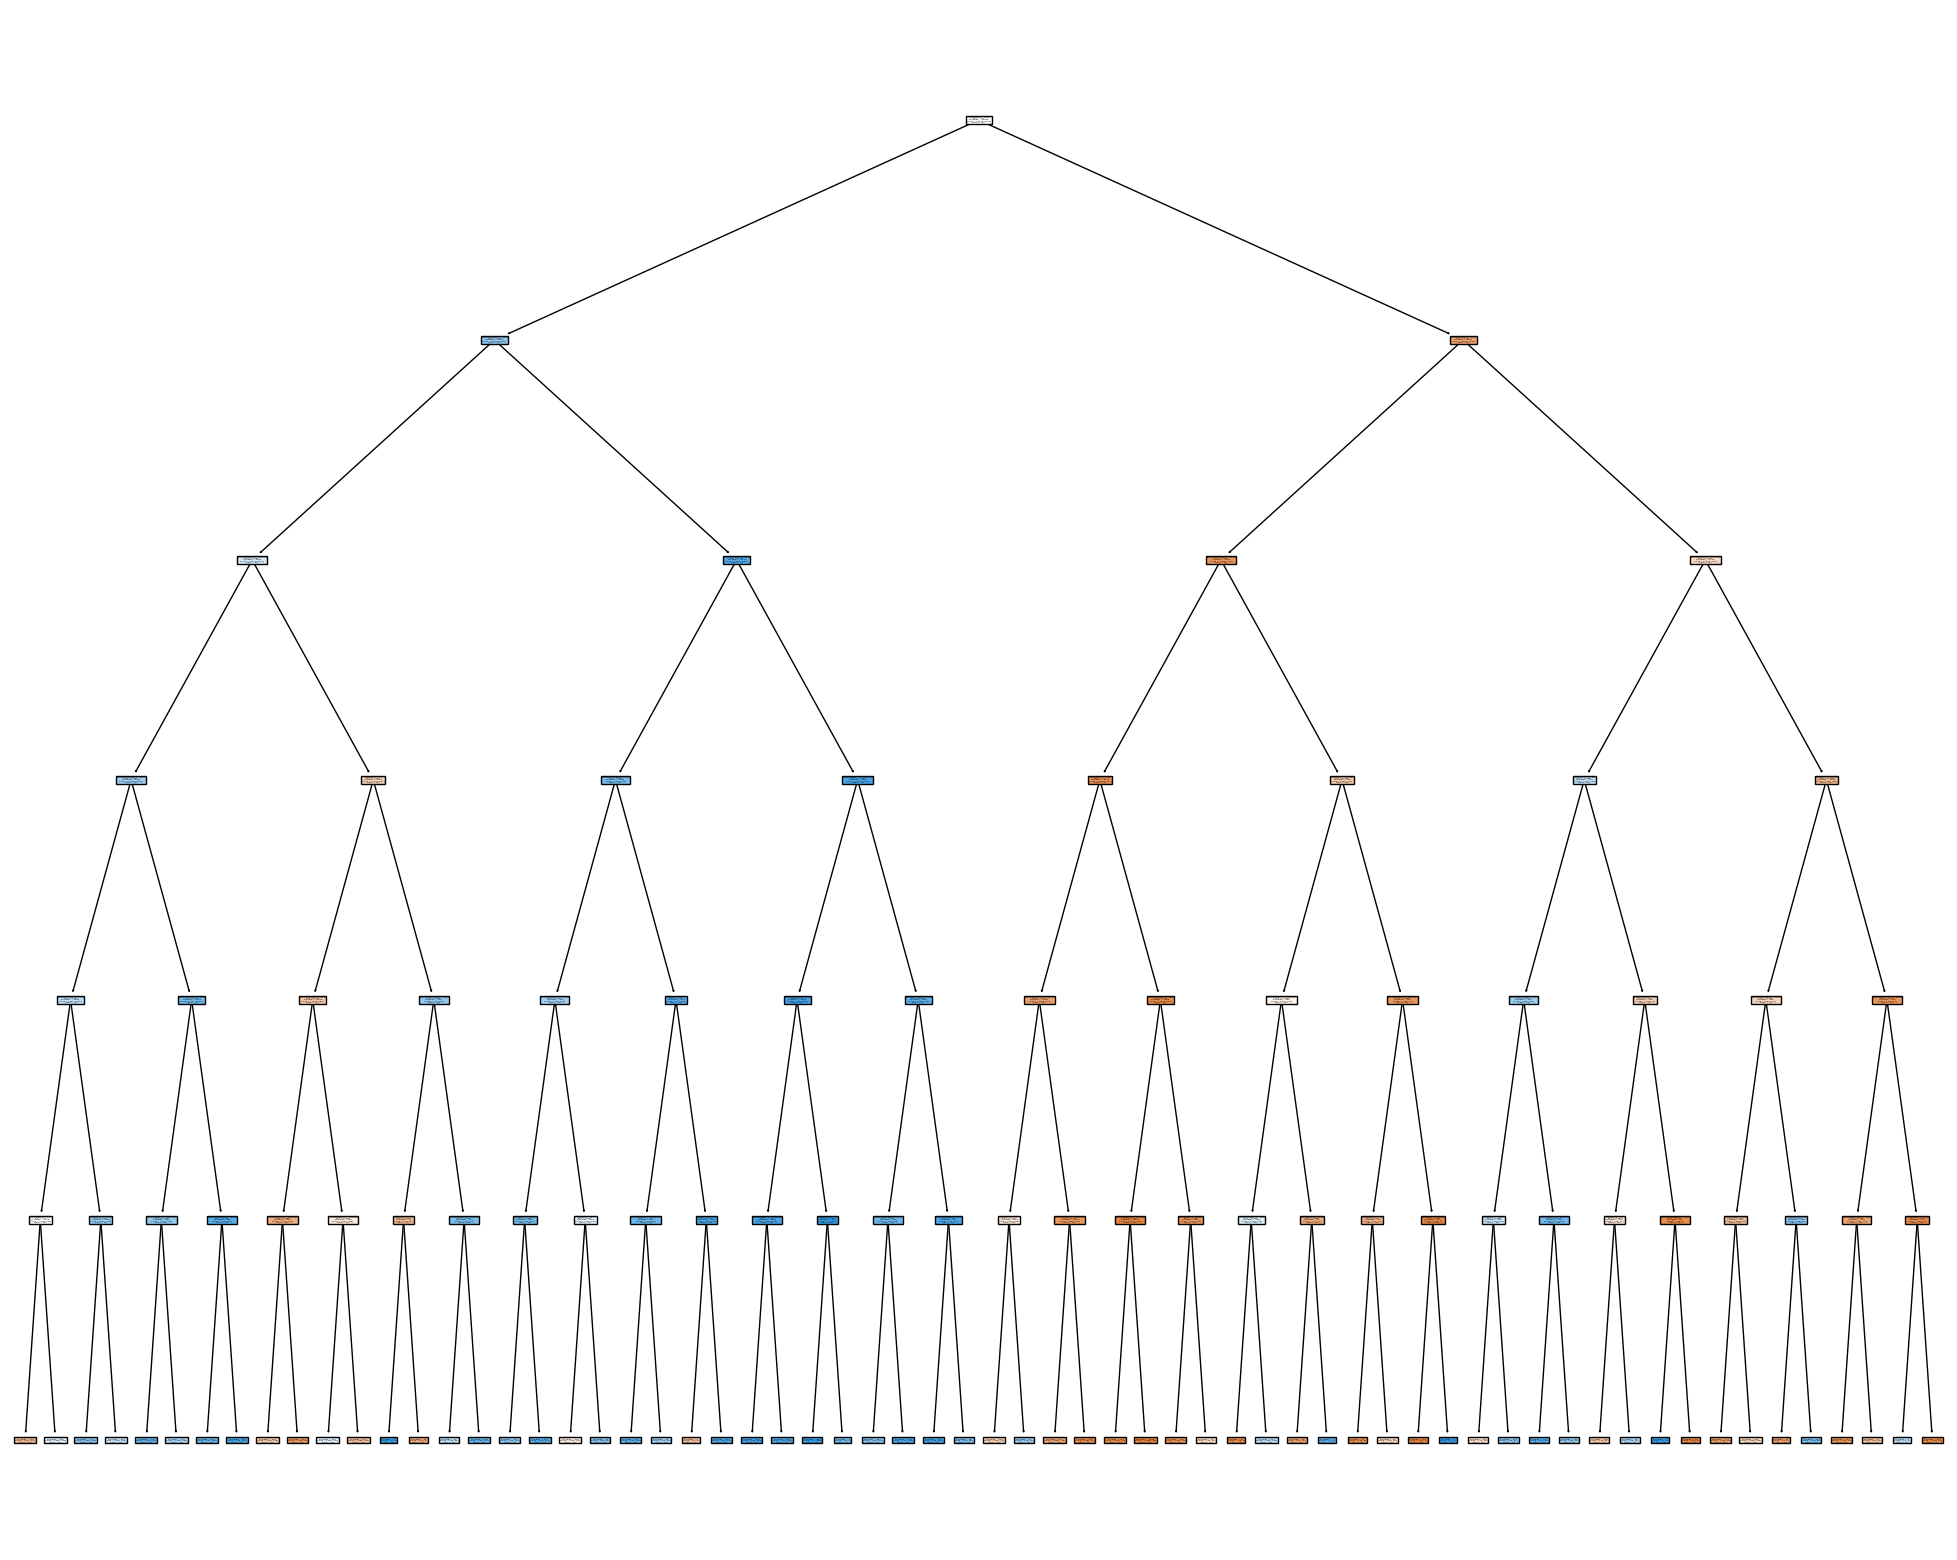

In [62]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DTC,feature_names=x_class.columns.values.tolist (),class_names=["Yes", "No"] , filled=True)

## Дерево регрессии

In [70]:
#param_grid = {
#    "max_depth": range(2,7),
#    "min_samples_split": range(2, 5),
#    "criterion": ['squared_error', 'friedman_mse', 'absolute_error', 'puisson']
#}
#
#gridseach = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid, scoring ='r2')
#gridseach.fit(x_train_r, y_train_r)
#gridseach.best_params_

# {'criterion': 'squared_error', 'max_depth': 6, 'min_samples_split': 2}

C:\Users\AlinaZ\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\AlinaZ\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\AlinaZ\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "C:\Users\AlinaZ\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params

{'criterion': 'squared_error', 'max_depth': 6, 'min_samples_split': 2}

In [89]:
DTR=DecisionTreeRegressor(criterion='squared_error', max_depth=6 , min_samples_split=2)
DTR.fit(x_train_r, y_train_r)
y_pred_r=pd.DataFrame(DTR.predict(x_test_r))

In [114]:
print(f'MAE: {mean_absolute_error(y_test_r, y_pred_r)}')
print(f'MSE: {mean_squared_error(y_test_r, y_pred_r)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test_r, y_pred_r))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test_r, y_pred_r)}')
print(f'R^2: {bag_reg.score(x_test_r, y_test_r)}')

MAE: 913.1553775727807
MSE: 1833485.1755686305
RMSE: 1354.062471073115
MAPE: 0.5091495560640935
R^2: 0.8968295701368639


In [92]:
# решающие правила (Decision Rules)
print(tree.export_text(DTR))

|--- feature_1 <= 2005.50
|   |--- feature_1 <= 2000.50
|   |   |--- feature_2 <= 2.15
|   |   |   |--- feature_1 <= 1997.50
|   |   |   |   |--- feature_2 <= 1.85
|   |   |   |   |   |--- feature_48 <= 0.50
|   |   |   |   |   |   |--- value: [1500.66]
|   |   |   |   |   |--- feature_48 >  0.50
|   |   |   |   |   |   |--- value: [997.68]
|   |   |   |   |--- feature_2 >  1.85
|   |   |   |   |   |--- feature_2 <= 1.95
|   |   |   |   |   |   |--- value: [2323.24]
|   |   |   |   |   |--- feature_2 >  1.95
|   |   |   |   |   |   |--- value: [1634.32]
|   |   |   |--- feature_1 >  1997.50
|   |   |   |   |--- feature_2 <= 1.65
|   |   |   |   |   |--- feature_48 <= 0.50
|   |   |   |   |   |   |--- value: [2090.04]
|   |   |   |   |   |--- feature_48 >  0.50
|   |   |   |   |   |   |--- value: [1590.69]
|   |   |   |   |--- feature_2 >  1.65
|   |   |   |   |   |--- feature_37 <= 0.50
|   |   |   |   |   |   |--- value: [2314.09]
|   |   |   |   |   |--- feature_37 >  0.50
|   |   | 

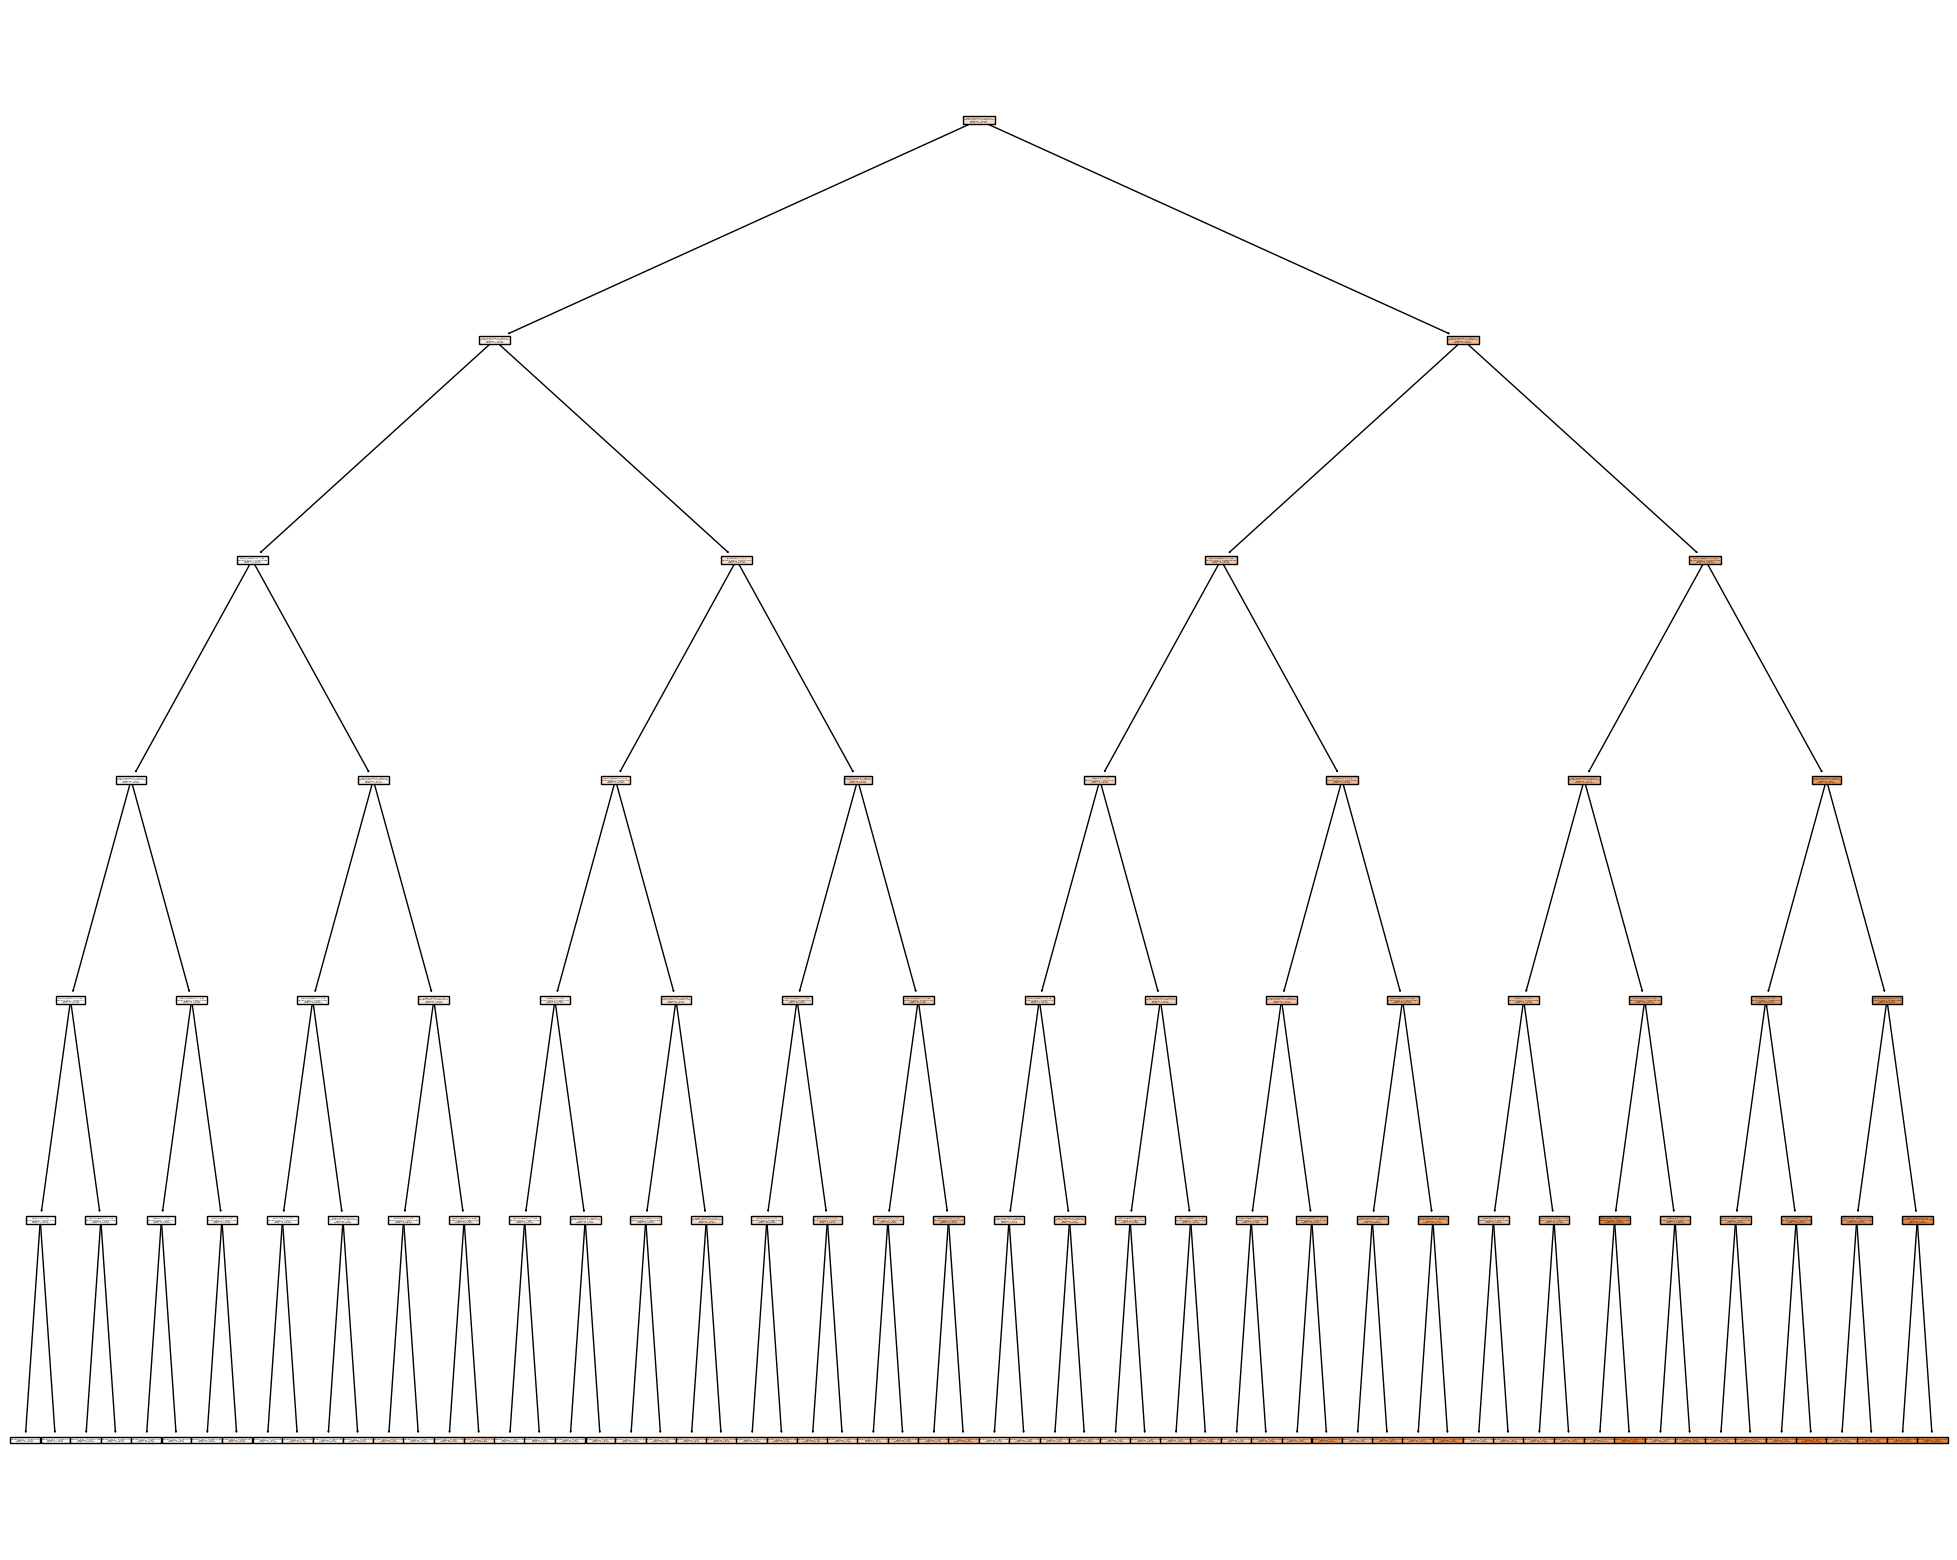

In [94]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DTR, feature_names=x_reg.columns.values.tolist (), filled=True)

## Ансамбли

### Bagging

In [103]:
bag_clf = BaggingClassifier().fit(x_train_c, y_train_c.values.ravel())
y_pred = bag_clf.predict(x_test_c)

print(classification_report(y_test_c, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      4077
           1       0.80      0.76      0.78      4125

    accuracy                           0.78      8202
   macro avg       0.78      0.78      0.78      8202
weighted avg       0.78      0.78      0.78      8202



In [115]:
bag_reg = BaggingRegressor().fit(x_train_r, y_train_r.values.ravel())
y_pred_r = bag_reg.predict(x_test_r)

print(f'MAE: {mean_absolute_error(y_test_r, y_pred_r)}')
print(f'MSE: {mean_squared_error(y_test_r, y_pred_r)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test_r, y_pred_r))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test_r, y_pred_r)}')
print(f'R^2: {bag_reg.score(x_test_r, y_test_r)}')

MAE: 920.9763392453937
MSE: 1857761.448331288
RMSE: 1362.9972297592128
MAPE: 0.6206289793667091
R^2: 0.8954635413683895


Случайный лес

In [131]:
bag_rfc = RandomForestClassifier().fit(x_train_c, y_train_c.values.ravel())
y_pred = bag_rfc.predict(x_test_c)

print(classification_report(y_test_c, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      4077
           1       0.80      0.82      0.81      4125

    accuracy                           0.81      8202
   macro avg       0.81      0.81      0.81      8202
weighted avg       0.81      0.81      0.81      8202



In [134]:
bag_reg = RandomForestRegressor().fit(x_train_r, y_train_r.values.ravel())
y_pred_r = bag_reg.predict(x_test_r)

print(f'MAE: {mean_absolute_error(y_test_r, y_pred_r)}')
print(f'MSE: {mean_squared_error(y_test_r, y_pred_r)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test_r, y_pred_r))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test_r, y_pred_r)}')
print(f'R^2: {bag_reg.score(x_test_r, y_test_r)}')

MAE: 857.9325846453266
MSE: 1647802.187904515
RMSE: 1283.6674755965873
MAPE: 0.5305543406205282
R^2: 0.9072779740349957


### GradientBoosting

In [118]:
grad_clf = GradientBoostingClassifier().fit(x_train_c, y_train_c.values.ravel())
y_pred_c = grad_clf.predict(x_test_c)

print(classification_report(y_test_c, y_pred_c))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      4077
           1       0.80      0.81      0.81      4125

    accuracy                           0.80      8202
   macro avg       0.80      0.80      0.80      8202
weighted avg       0.80      0.80      0.80      8202



In [123]:
grad_reg = GradientBoostingRegressor().fit(x_train_r, y_train_r.values.ravel())
y_pred_r = grad_reg.predict(x_test_r)

print(f'MAE: {mean_absolute_error(y_test_r, y_pred_r)}')
print(f'MSE: {mean_squared_error(y_test_r, y_pred_r)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test_r, y_pred_r))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test_r, y_pred_r)}')
print(f'R^2: {grad_reg.score(x_test_r, y_test_r)}')

MAE: 986.7447991928543
MSE: 1999066.852607284
RMSE: 1413.8836064567988
MAPE: 0.4332687703141878
R^2: 0.8875122693889924


### Stacking

In [139]:
stack_clf = StackingClassifier(estimators=[('en', DecisionTreeClassifier(criterion='entropy')),
('gini', DecisionTreeClassifier(criterion='gini'))],
final_estimator=KNeighborsClassifier(10)).fit(x_train_c, y_train_c.values.ravel())

y_pred_c = stack_clf.predict(x_test_c)

print(classification_report(y_test_c, y_pred_c))

              precision    recall  f1-score   support

           0       0.82      0.60      0.69      4077
           1       0.68      0.87      0.77      4125

    accuracy                           0.73      8202
   macro avg       0.75      0.73      0.73      8202
weighted avg       0.75      0.73      0.73      8202



In [128]:
stack_clf = StackingRegressor(estimators=[('en', DecisionTreeRegressor(max_depth=3)),
                                          ('lin_reg', LinearRegression())],
                               final_estimator=LinearRegression()).fit(x_train_r, y_train_r.values.ravel())

y_pred_r = stack_clf.predict(x_test_r)

print(f'MAE: {mean_absolute_error(y_test_r, y_pred_r)}')
print(f'MSE: {mean_squared_error(y_test_r, y_pred_r)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test_r, y_pred_r))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test_r, y_pred_r)}')
print(f'R^2: {stack_clf.score(x_test_r, y_test_r)}')

MAE: 1260.7845019275428
MSE: 3036240.8426296026
RMSE: 1742.4812316434293
MAPE: 0.569319315889819
R^2: 0.829150365066379


### XGBoost

In [140]:
Cat= CatBoostClassifier()

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = Cat.grid_search(grid,
                                       X=x_train_c,
                                       y=y_train_c,)

0:	learn: 0.6793445	test: 0.6796916	best: 0.6796916 (0)	total: 157ms	remaining: 2m 36s
1:	learn: 0.6665358	test: 0.6673497	best: 0.6673497 (1)	total: 164ms	remaining: 1m 22s
2:	learn: 0.6539421	test: 0.6553862	best: 0.6553862 (2)	total: 170ms	remaining: 56.6s
3:	learn: 0.6423057	test: 0.6444528	best: 0.6444528 (3)	total: 180ms	remaining: 44.7s
4:	learn: 0.6306634	test: 0.6333391	best: 0.6333391 (4)	total: 186ms	remaining: 37s
5:	learn: 0.6193985	test: 0.6226719	best: 0.6226719 (5)	total: 196ms	remaining: 32.5s
6:	learn: 0.6093895	test: 0.6130929	best: 0.6130929 (6)	total: 207ms	remaining: 29.4s
7:	learn: 0.6000538	test: 0.6042983	best: 0.6042983 (7)	total: 216ms	remaining: 26.8s
8:	learn: 0.5912344	test: 0.5959786	best: 0.5959786 (8)	total: 226ms	remaining: 24.8s
9:	learn: 0.5833741	test: 0.5887186	best: 0.5887186 (9)	total: 236ms	remaining: 23.4s
10:	learn: 0.5758389	test: 0.5815048	best: 0.5815048 (10)	total: 248ms	remaining: 22.3s
11:	learn: 0.5677820	test: 0.5736195	best: 0.5736195

In [141]:
y_pred_c=Cat.predict(x_test_c)
print(classification_report(y_test_c, y_pred_c))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      4077
           1       0.81      0.83      0.82      4125

    accuracy                           0.82      8202
   macro avg       0.82      0.82      0.82      8202
weighted avg       0.82      0.82      0.82      8202



In [142]:
Cat_reg = CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = Cat_reg.grid_search(grid,
                                       X=x_train_r,
                                       y=y_train_r,)

0:	learn: 6651.5671769	test: 6713.9168826	best: 6713.9168826 (0)	total: 14.4ms	remaining: 14.4s
1:	learn: 6479.2863909	test: 6541.1475546	best: 6541.1475546 (1)	total: 18.7ms	remaining: 9.34s
2:	learn: 6313.3601257	test: 6375.0174342	best: 6375.0174342 (2)	total: 27.5ms	remaining: 9.14s
3:	learn: 6154.2218278	test: 6214.1935629	best: 6214.1935629 (3)	total: 37.4ms	remaining: 9.3s
4:	learn: 5997.8307239	test: 6056.5410981	best: 6056.5410981 (4)	total: 46.9ms	remaining: 9.33s
5:	learn: 5844.0150956	test: 5901.5798551	best: 5901.5798551 (5)	total: 55.4ms	remaining: 9.18s
6:	learn: 5696.5130343	test: 5753.3462354	best: 5753.3462354 (6)	total: 59.6ms	remaining: 8.46s
7:	learn: 5556.0166418	test: 5612.7294714	best: 5612.7294714 (7)	total: 67.3ms	remaining: 8.35s
8:	learn: 5415.8634047	test: 5472.1792459	best: 5472.1792459 (8)	total: 73.4ms	remaining: 8.08s
9:	learn: 5284.9692108	test: 5340.2319019	best: 5340.2319019 (9)	total: 80ms	remaining: 7.92s
10:	learn: 5156.4548025	test: 5210.1919832	

In [143]:
y_pred_r=Cat_reg.predict(x_test_r)

print(f'MAE: {mean_absolute_error(y_test_r, y_pred_r)}')
print(f'MSE: {mean_squared_error(y_test_r, y_pred_r)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test_r, y_pred_r))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test_r, y_pred_r)}')
print(f'R^2: {Cat_reg.score(x_test_r, y_test_r)}')

MAE: 736.3703865712855
MSE: 1165080.6276227762
RMSE: 1079.3890066249407
MAPE: 0.3191547202232281
R^2: 0.9344407738994807
